k_nearest_neighbor.py를 이 파일과 하나로 합쳤습니다.

# k-Nearest Neighbor (kNN) exercise

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

### 사용할 데이터 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10  # 케라스가 이미 설치돼 있다면 간편하게 데이터를 가져올 수 있다.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Using TensorFlow backend.


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


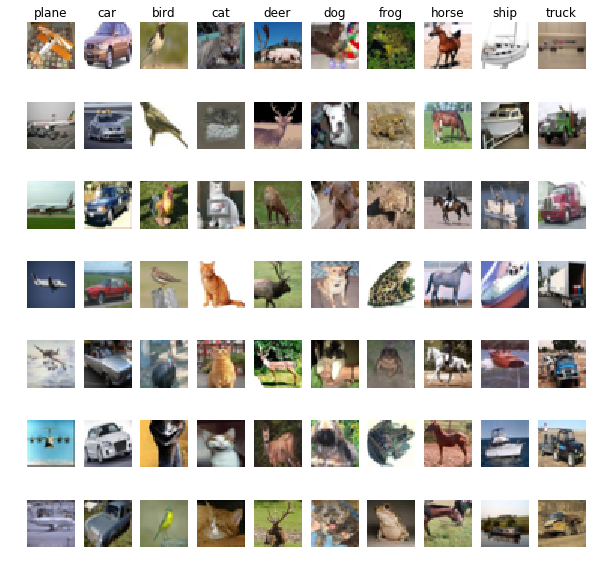

In [2]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
# 어차피 연습이므로, 데이터 중 일부만 사용한다.
num_training = 5000
mask = list(range(5000))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(500))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


### kNN 분류기 만들기

In [4]:
class KNearestNeighbor():
    """ 
    a kNN classifier with L2 distance 
    """

    def train(self, X, y):
        '''훈련에서는 별다른 연산 없이 저장만 해둔다'''
        self.X_train = np.int32(X)
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        num_loops는 for문을 몇 번 사용해서 계산할 것인지를 나타낸다.
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        테스트 데이터 X와 훈련 데이터 self.X_train 사이의 거리를 측정.
        (num_test, num_train) 크기의 dists 배열을 반환한다.
        dists[i, j]: i번째 테스트 데이터와 j번째 훈련 데이터 사이의 거리
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        
        # for문 2번 사용
        for i in range(num_test):
            for j in range(num_train):
                dists[i, j] = np.sqrt(np.sum(np.square(X[i] - self.X_train[j], dtype=np.int32)))
                
        return dists

    def compute_distances_one_loop(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        
        # for문 1번 사용
        for i in range(num_test):
            dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i], dtype=np.int32), axis=1))
            
        return dists

    def compute_distances_no_loops(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        
        # for문을 사용하지 않음
        dists = np.sqrt(np.sum(np.square(X, dtype=np.int32), axis=1, keepdims=True) \
                        + np.sum(np.square(self.X_train, dtype=np.int32), axis=1) \
                        - 2 * np.dot(X, self.X_train.T))
        

        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):            
            closest_y = [] # 길이가 k인 리스트. i번째 테스트 데이터와 k최근접 레이블을 담고 있다.
            np.argsort(dists[i]) < k
            closest_y = self.y_train[np.argsort(dists[i]) < k]
            y_pred[i] = np.bincount(closest_y).argmax() # closest_y에서 가장 빈도가 큰 레이블을 y_pred[i]에 담는다.

        return y_pred

### l2 거리 시각화

In [5]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


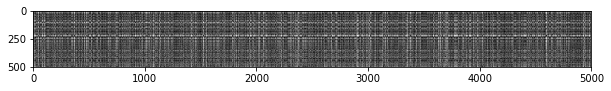

In [6]:
# 거리 행렬을 시각화한다. 각각의 행은 테스트 샘플로서, 훈련 샘플과의 거리를 나타낸다.
plt.imshow(dists, interpolation='none')
plt.show()   # 색이 흴수록 거리가 멀다.

### kNN 분류기 성능 확인

In [7]:
# k = 1
y_test_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = num_correct / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 38 / 500 correct => accuracy: 0.076000


In [8]:
# k = 5
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = num_correct / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 60 / 500 correct => accuracy: 0.120000


k의 크기를 늘려서 다수결 투표를 하니 조금 성능이 올라갔다.

### 벡터 구현상의 오류 여부 확인

벡터화된 계산은 속도가 빠르지만, 이를 코드화하는 과정에서 실수할 가능성이 높다. 따라서 이를 확인해준다.

In [9]:
# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.

dists_one = classifier.compute_distances_one_loop(X_test)
difference = np.linalg.norm(dists - dists_one, ord='fro')

print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [10]:
dists_two = classifier.compute_distances_no_loops(X_test)
difference = np.linalg.norm(dists - dists_two, ord='fro')

print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


### 벡터화 기법의 속도 향상 확인 

In [11]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 34.463834 seconds
One loop version took 34.792954 seconds
No loop version took 3.507646 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [12]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {} # k 값이 key이고, 폴드 별 accuracy가 들어있는 리스트가 value인 딕셔너리.

for k in k_choices:
    accuracies = []
    for i in range(num_folds):
        train_set = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])
        lebel_set = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])
        classifier.train(train_set, lebel_set)
        pred = classifier.predict(X_train_folds[i], k=k)
        acc = np.sum(pred == y_train_folds[i]) / pred.size
        accuracies.append(acc)
    k_to_accuracies[k] = accuracies

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    print('k = %d, accuracy = %f' % (k, np.mean(k_to_accuracies[k])))

k = 1, accuracy = 0.099400
k = 3, accuracy = 0.103000
k = 5, accuracy = 0.103400
k = 8, accuracy = 0.101800
k = 10, accuracy = 0.102000
k = 12, accuracy = 0.101600
k = 15, accuracy = 0.102400
k = 20, accuracy = 0.104400
k = 50, accuracy = 0.105600
k = 100, accuracy = 0.104200


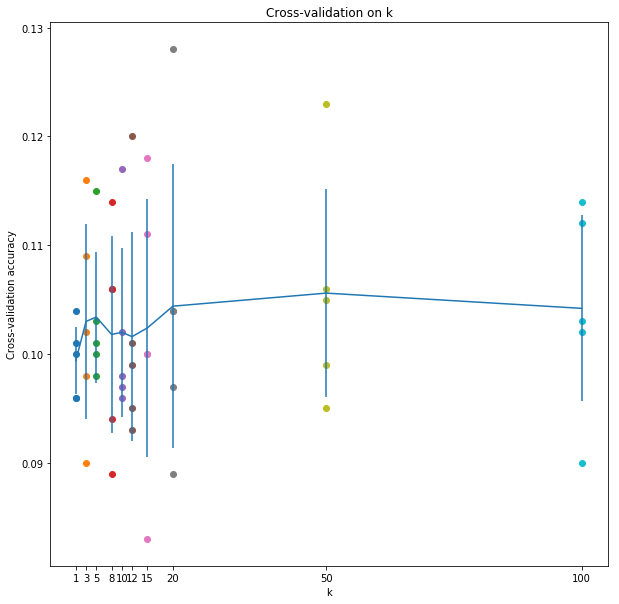

In [13]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)
    
# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.xticks(k_choices)
plt.show()

In [14]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test data.
best_k = 50

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 49 / 500 correct => accuracy: 0.098000


이미지 분류 문제에는 kNN을 쓰지 말자.